In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import datetime

from dataset import train, val, test
from helper_functions import plot_loss, plot_accuracy, validation, cal_acc, evaluate_on_training_set

# Data & DataLoader

In [2]:
train1=train("./Data/SPY_train_2008_2016.csv")
val1=val("./Data/SPY_train_2008_2016.csv")
test1=test("./Data/SPY_test_2016_2017.csv")

/home/jovyan/DLBigproject/dataset.py:31: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  mean_deviation = typical_price.rolling(ndays).apply(lambda x: pd.Series(x).mad())
/home/jovyan/DLBigproject/dataset.py:165: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  mean_deviation = typical_price.rolling(ndays).apply(lambda x: pd.Series(x).mad())
/home/jovyan/DLBigproject/dataset.py:296: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to spe

In [3]:
bs_val=16
train1_loader=DataLoader(train1,batch_size=bs_val,shuffle=False)
val1_loader=DataLoader(val1,batch_size=bs_val,shuffle=False)
test1_loader=DataLoader(test1,batch_size=bs_val,shuffle=False)

# Data visualisation

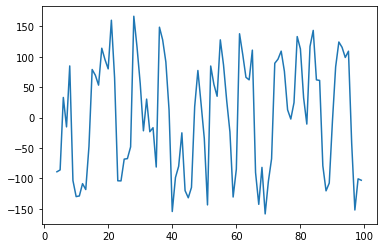

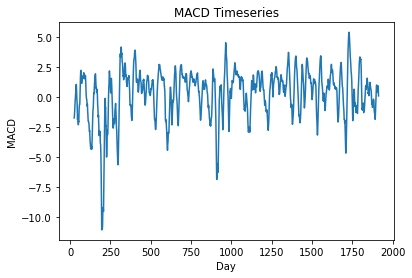

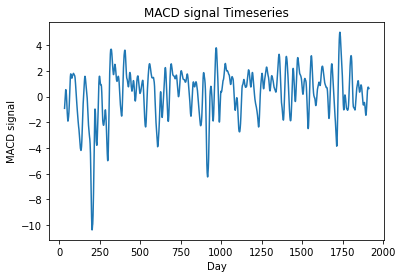

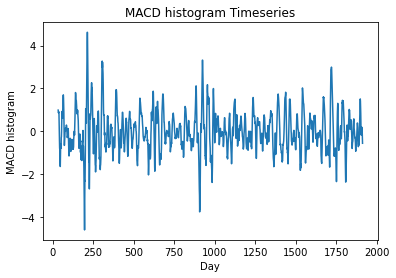

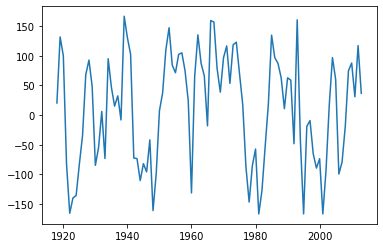

In [6]:
train1.plot_CCI()
train1.plot_macd()
train1.plot_signal()
train1.plot_macd_hist()
val1.plot_CCI()

# Model & Train

In [5]:
class StockModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.padding=nn.ZeroPad2d(1)
        self.conv1=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3),
            nn.ReLU()
        )
        
        self.conv2=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(3, 2)),
            nn.ReLU()
        )
        
        self.linear=nn.Linear(32*8*2,2)
        
        self.act=nn.Softmax()
        
        self.history={'train_accuracy':[],'train_loss':[],'validation_accuracy':[],'validation_loss':[]}
        
        
    def forward(self,x):
#         print(x.size())
        out=self.padding(x)
        out=self.conv1(out)
        out=self.conv2(out)
#         print(out.size())
        out=out.view(out.size(0),-1)
        out=self.linear(out)
        out=self.act(out) 
#         print(out.size())
        return out

In [6]:
epochs=20
model=StockModel()
loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=0.01)
model

StockModel(
  (padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 2), stride=(1, 1))
    (1): ReLU()
  )
  (linear): Linear(in_features=512, out_features=2, bias=True)
  (act): Softmax(dim=None)
)

In [30]:
def train_model(model,loss_func,optimizer,epochs, train_loader,validation_loader):
    for epoch in range(epochs):
        model.train()
        total_train_acc=0
        total_train_loss=0
        for images,labels in train_loader:
            outputs=model(images)
    #         print(outputs)
            loss=loss_func(outputs,torch.flatten(labels.long()))
            total_train_loss+=loss.item()
            acc=cal_acc(outputs,labels)
            total_train_acc+=acc

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss=total_train_loss/len(train_loader)
        train_acc=total_train_acc/len(train_loader)

        model.eval()
        val_loss,val_acc,_,_=validation(model,validation_loader,loss_func)
    #     print(val_loss,val_acc)
    
        model.history['train_accuracy'].append(train_acc)
        model.history['validation_accuracy'].append(val_acc)
        model.history['train_loss'].append(train_loss)
        model.history['validation_loss'].append(val_loss)

        print("Epoch: {}/{} @ {} ".format(epoch+1, epochs,str(datetime.datetime.now())),
                          "\n",
                          "Training Loss: {:.4f} - ".format(train_loss),
                          "Training Accuracy: {:.4f} - ".format(train_acc),
                          "Validation Loss: {:.4f} - ".format(val_loss),
                          "Validation Accuracy: {:.4f}".format(val_acc))
        
    return model


In [31]:
train_model(model,loss_function,optimizer,epochs, train1_loader,val1_loader)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/20 @ 2021-04-30 05:03:46.155477  
 Training Loss: 0.7623 -  Training Accuracy: 0.5451 -  Validation Loss: 0.8695 -  Validation Accuracy: 0.4437
Epoch: 2/20 @ 2021-04-30 05:03:46.669492  
 Training Loss: 0.7661 -  Training Accuracy: 0.5472 -  Validation Loss: 0.8695 -  Validation Accuracy: 0.4437
Epoch: 3/20 @ 2021-04-30 05:03:47.208765  
 Training Loss: 0.7661 -  Training Accuracy: 0.5472 -  Validation Loss: 0.8695 -  Validation Accuracy: 0.4437
Epoch: 4/20 @ 2021-04-30 05:03:47.681779  
 Training Loss: 0.7661 -  Training Accuracy: 0.5472 -  Validation Loss: 0.8695 -  Validation Accuracy: 0.4437
Epoch: 5/20 @ 2021-04-30 05:03:48.134850  
 Training Loss: 0.7661 -  Training Accuracy: 0.5472 -  Validation Loss: 0.8695 -  Validation Accuracy: 0.4437
Epoch: 6/20 @ 2021-04-30 05:03:48.604902  
 Training Loss: 0.7661 -  Training Accuracy: 0.5472 -  Validation Loss: 0.8695 -  Validation Accuracy: 0.4437
Epoch: 7/20 @ 2021-04-30 05:03:49.061353  
 Training Loss: 0.7661 -  Training Accu

StockModel(
  (padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 2), stride=(1, 1))
    (1): ReLU()
  )
  (linear): Linear(in_features=512, out_features=2, bias=True)
  (act): Softmax(dim=None)
)

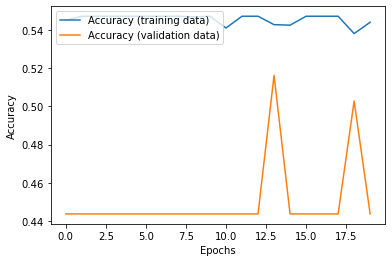

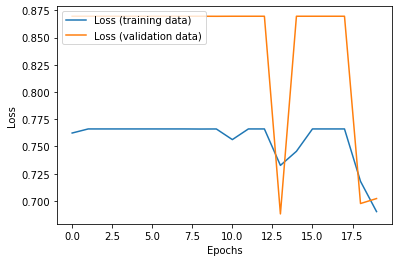

In [34]:
plot_accuracy(model)
plot_loss(model)

In [12]:
model.eval()
test_loss,test_acc,outputs,labels=validation(model,test1_loader,loss_function)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# Save model & Load model

In [13]:
savepath="./models/train2model.pt"
torch.save(model,savepath)

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type StockModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [7]:
load_model=StockModel()
load_model=torch.load("./models/train1model.pt")

In [8]:
test_loss,test_acc,outputs,labels=validation(load_model,test1_loader,loss_function)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       193
         1.0       0.56      1.00      0.71       241

    accuracy                           0.56       434
   macro avg       0.28      0.50      0.36       434
weighted avg       0.31      0.56      0.40       434

         Pred 0  Pred 1
Label 0       0     193
Label 1       0     241


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


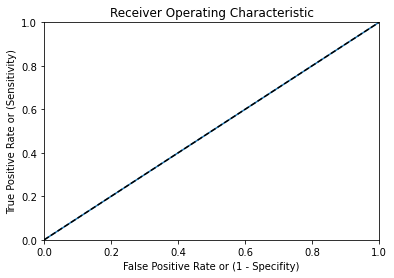

In [11]:
result,fig=evaluate_on_training_set(torch.cat(labels),torch.cat(outputs))
print(result['AUC'])
print(result['report'])
df=pd.DataFrame(data=result['ConMatrix'],index=['Label 0','Label 1'],columns=['Pred 0','Pred 1'])
print(df)